In [40]:
import torch

from torch import nn
from torch import optim
from time import gmtime, strftime
from tensorboardX import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt


import os

# from resnet2d_ecg import *
# from data_generator_ecg import *
# from tools import *

from model import densenet169, resnet50, resnet101, fusenet,\
    GLOBAL_BRANCH_DIR, LOCAL_BRANCH_DIR
from common import config
from utils import TrainClock, save_args, AverageMeter, AUCMeter,calculate_accuracy
from dataset import get_dataloaders
from dataset import calc_data_weights
from Attention_Resnet.model.residual_attention_network_mura import ResidualAttentionModel_92 as Attentionnet
from efficientunet import *


from train import Session

In [42]:
torch.backends.cudnn.benchmark = True
LOSS_WEIGHTS = calc_data_weights()


torch.manual_seed(1)
torch.cuda.manual_seed(1)
# torch.cuda.set_device(2)
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
num_classes = 1
#model = Globalocal(depth=34, num_classes=num_classes, with_lateral = [0,0,1,1], Net_type = 'with_global_detail').cuda()
# model = Globalocal(depth=34, num_classes=num_classes, with_lateral = False , Net_type = 'with_global').cuda()
# model = nn.DataParallel(model)

# model = ResNet(dataset='calc', depth=10, num_classes=num_classes).cuda()
# global_branch = torch.load(GLOBAL_BRANCH_DIR)['net']
# local_branch = torch.load(LOCAL_BRANCH_DIR)['net']
# net = fusenet(global_branch, local_branch)
# del global_branch, local_branch

# net = resnet50()
# net = Attentionnet()
net = EfficientNet.from_name('efficientnet-b7', n_classes=1, pretrained=False)


net = net.cuda()
sess = Session(config, net=net)

In [43]:
valid_loader = get_dataloaders('valid', batch_size=1,
                               shuffle=False)

In [44]:
model_load_path = r'E:\Xing\Data\MURA-v1.1\effb7_lrcos_wbce_20201223\model'
model_name = r'\best_model.pth.tar'
continue_path = model_load_path+model_name
sess.load_checkpoint(continue_path)

In [45]:
criterion = nn.BCELoss()

In [46]:
net.cuda()
# model.load_state_dict(checkpoint['state_dict'])

EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_swish): Swish()
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (swish): Swish()
      (_depthwise_conv): Conv2dSamePadding(64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False)
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dSamePadding(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (_se_expand): Conv2dSamePadding(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (_project_conv): Conv2dSamePadding(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (_bn2): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    )
    (1): MBConvBlock(
      (swish): Swish()
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_siz

In [47]:
# torch.cuda.set_device(3)
# from utils import calculate_accuracy

losses_val = AverageMeter('loss')
accuracies_val = AverageMeter('acc')
net.eval()
y = []
pred = []

#fileio.maybe_make_new_dir(result_path)
with torch.no_grad():
    for j, data in tqdm(enumerate(valid_loader)):
        targets_val = data['label'].float().cuda()
        images_val = data['image'].float().cuda()
        outputs_val = net(images_val)
        loss_val = criterion(outputs_val, targets_val)
        
#         add_gl_image_index(images_val, patches_val, outputs_val, targets_val,  writer, subset='val', epoch=0, index = j)
        
        acc_val = calculate_accuracy(outputs_val, targets_val)
        losses_val.update(loss_val.item(), targets_val.size(0))
        accuracies_val.update(acc_val, targets_val.size(0))
        y.append(targets_val.cpu().numpy())
        pred.append(outputs_val.cpu().numpy())

print('val_loss: ', losses_val.avg, 'val_acc: ', accuracies_val.avg)


3197it [07:49,  6.81it/s]

val_loss:  0.5423486960428706 val_acc:  0.7178604970347036


In [48]:
import numpy as np

In [49]:
y= np.asarray(y)
pred= np.asarray(pred).squeeze()

In [50]:
y,pred

(array([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([0.64287597, 0.691805  , 0.77381027, ..., 0.15177196, 0.2796317 ,
        0.09006868], dtype=float32))

In [51]:
y.shape

(3197, 1)

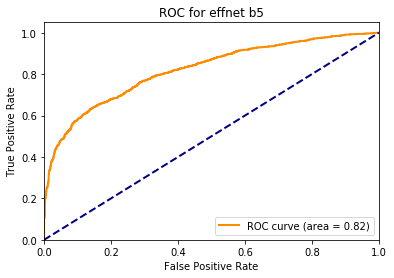

In [52]:
from sklearn import metrics

%matplotlib inline

fpr, tpr, thresholds = metrics.roc_curve(y, pred)

roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for effnet b7')
plt.legend(loc="lower right")
plt.show()

In [53]:
from sklearn.metrics import confusion_matrix

threshold = 0.35

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

In [54]:
cm[0,0]/sum(cm[0,:]), cm[1,1]/sum(cm[1,:])

(0.41511697660467906, 0.9143790849673202)

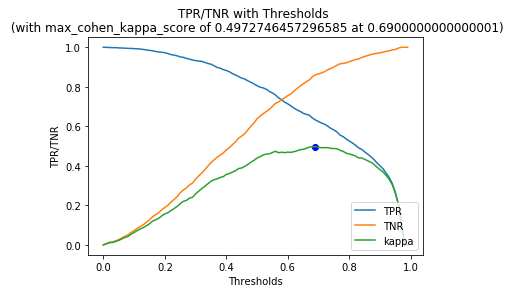

In [55]:
import numpy
from sklearn.metrics import cohen_kappa_score
mali = []
beni = []
cohen = []
tt = numpy.arange(0,1,0.01)
for thres in tt:
#     print(thres)
    pred_t = pred > thres
    pred_t.astype(int)
    cm = confusion_matrix(y,pred_t)
    mali.append(cm[1,1]/sum(cm[1,:]))
    beni.append(cm[0,0]/sum(cm[0,:]))
    cohen.append(cohen_kappa_score(y,pred_t))
# print(thresholds)
plt.figure(),plt.plot(tt,mali,label='TPR'),plt.plot(tt,beni,label='TNR'),plt.plot(tt,cohen,label='kappa')
plt.xlabel('Thresholds')
plt.ylabel('TPR/TNR')

plt.legend(loc="lower right")


net_max = cohen.index(max(cohen))
plt.title('TPR/TNR with Thresholds \n (with max_cohen_kappa_score of {} at {})'.format(max(cohen),tt[net_max]))
plt.scatter(tt[net_max], cohen[net_max], color='b')
plt.show()

In [56]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



#     plt.figure(figsize=(4, 3))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

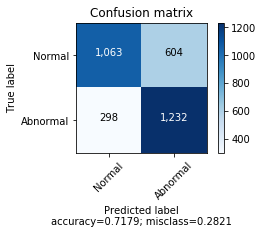

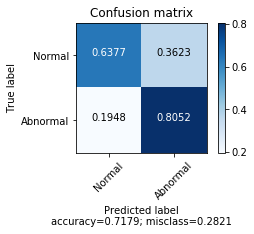

In [57]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= False)
plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= True)

In [25]:
a = 0.7

In [26]:
a>0.5

True

In [28]:
1-(a>0.50)

0

In [43]:
a = torch.rand(3,3)

In [44]:
a

tensor([[0.2847, 0.4820, 0.1940],
        [0.7670, 0.0734, 0.9933],
        [0.7518, 0.1041, 0.5967]])

In [35]:
a.shape

torch.Size([3, 3])

In [36]:
b = [0,2,1]

In [37]:
b = torch.tensor(b)

In [55]:
bb = b.reshape(-1,1)

In [54]:
b

tensor([0, 2, 1])

In [39]:
l = F.nll_loss(a,b)

In [40]:
l

tensor(-0.5024)

In [46]:
sm = nn.LogSoftmax(dim=1)

In [47]:
aa = sm(a)

In [48]:
aa

tensor([[-1.1415, -0.9442, -1.2322],
        [-1.0130, -1.7066, -0.7866],
        [-0.8669, -1.5147, -1.0220]])

In [56]:
l = F.nll_loss(aa,bb)

RuntimeError: multi-target not supported at ..\aten\src\THNN/generic/ClassNLLCriterion.c:20

In [53]:
l

tensor(1.1476)

In [59]:
a = np.random.rand(3,4)

In [66]:
b = np.random.rand(2,4)

In [72]:
t = [a,b]

In [73]:
np.array(t).shape

(2,)

In [74]:
t.pop()

array([[0.255251, 0.802925, 0.39936 , 0.069087],
       [0.192725, 0.195726, 0.765414, 0.068067]])

In [75]:
t.pop()

array([[0.269292, 0.443954, 0.016551, 0.314709],
       [0.903049, 0.930926, 0.752409, 0.969705],
       [0.035113, 0.174226, 0.025869, 0.240254]])

In [76]:
t[0]

IndexError: list index out of range